# Rating de imagens
Testes de algoritmos para dar uma nota de qualidade ara cada imagem.

In [2]:
# importar bibliotecas necessárias
from PIL import Image
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000


## Imagens de teste
Para testar a eficiência do algoritmo, foram criadas várias imagens de 4x4 px ampliadas para 32x32 px.

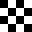

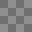

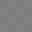

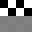

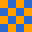

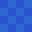

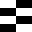

In [3]:
img0a = Image.open('imgs_exemplo/xadrez-0.png')
img0b = Image.open('imgs_exemplo/listras-0.png')
img1 = Image.open('imgs_exemplo/xadrez-1.png')
img2 = Image.open('imgs_exemplo/xadrez-2.png')
img3 = Image.open('imgs_exemplo/xadrez-3.png')
img4 = Image.open('imgs_exemplo/xadrez-4.png')
img5 = Image.open('imgs_exemplo/xadrez-5.png')
img6 = Image.open('imgs_exemplo/xadrez-6.png')
img7 = Image.open('imgs_exemplo/listras-1.png')

display(img0a)
display(img0b)
display(img1)
display(img2)
display(img3)
display(img4)
display(img5)
display(img6)
display(img7)

## Passo a passo para dar uma nota para a imagem

### 1- Converter para Lab e obter o ΔE*
O CIELAB ΔE* calcula a diferença perceptual de cores, não apenas a matemática. A medida é ajustada para como humanos percebem as diferentes cores. Para calcular essa medida, as imagens precisam ser convertidas do espaço de cor RGB para o espaço Lab.
Por questões de praticidade, criei uma função que já faz a conversão e mede a distância entre 2 pixels.

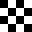

99.99998490203575


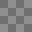

11.814090519180438


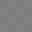

1.9028307665974282


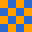

76.91213897021737


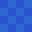

8.226374950880052


In [4]:
# pequeno patch para o cálculo do dE que usa uma versão antiga do numpy
import numpy

def patch_asscalar(a):
    return a.item()

setattr(numpy, "asscalar", patch_asscalar)


def obter_dE(px1, px2):
    #converter cada pixel para Lab
    rgb1 = sRGBColor(px1[0]/255, px1[1]/255, px1[0]/255)
    lab1 = convert_color(rgb1, LabColor)
    rbg2 = sRGBColor(px2[0]/255, px2[1]/255, px2[0]/255)
    lab2 = convert_color(rbg2, LabColor)
    #calcular a diferença
    dE = delta_e_cie2000(lab1, lab2)
    return dE

#exemplo de uso comparando os dois primeiros quadrados
display(img1)
print(obter_dE(img1.getpixel((0, 0)), img1.getpixel((0, 8))))
display(img2)
print(obter_dE(img2.getpixel((0, 0)), img2.getpixel((0, 8))))
display(img3)
print(obter_dE(img3.getpixel((0, 0)), img3.getpixel((0, 8))))
display(img5)
print(obter_dE(img5.getpixel((0, 0)), img5.getpixel((0, 8))))
display(img6)
print(obter_dE(img6.getpixel((0, 0)), img6.getpixel((0, 8))))


### 2- Iterar sobre pixels vizinhos
A ideia é que o algoritmo compare as cores de cada pixel com seus 4 vizinhos laterais. Para isso precisamos de um iterador que obtenha os valores do pixel vizinho.

In [5]:
def valores_vizinhos(loaded_img, x,y):
    cima = loaded_img[x,y-1]
    direita = loaded_img[x+1, y]
    baixo = loaded_img[x, y+1]
    esquerda = loaded_img[x-1, y]
    return [cima, direita, baixo, esquerda]

# Iterador que descarta um pixel de borda para garantir que os vizinhos existam
def iterador(img):
    largura, altura = img.size
    loaded_img = img.load()
    for linha in range(1, altura-1):
        for coluna in range(1, largura-1):
            print(valores_vizinhos(loaded_img, coluna, linha))

iterador(img0a)
print('----')
iterador(img0b)

[(255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)]
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
[(255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)]
----
[(255, 255, 255), (255, 255, 255), (255, 255, 255), (0, 0, 0)]
[(0, 0, 0), (255, 255, 255), (0, 0, 0), (0, 0, 0)]
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (255, 255, 255)]
[(255, 255, 255), (0, 0, 0), (255, 255, 255), (255, 255, 255)]


A partir do momento em que esse iterador anda, ele repete o cálculo do ΔE* desnecessariamente várias vezes. Quando está no pixel um, o vizinho à direita é o 2. Quando está no pixel 2, o vizinho à esquerda é o 1. Podemos evitar isso restringindo a análise de vizinhos a partir de linhas e colunas ímpares/pares:
- **linha par**: só analisa vizinhos em colunas pares
- **linha ímpar**: só analisa vizinhos em colunas ímpares

In [6]:
def valores_vizinhos(loaded_img, x,y):
    cima = loaded_img[x,y-1]
    direita = loaded_img[x+1, y]
    baixo = loaded_img[x, y+1]
    esquerda = loaded_img[x-1, y]
    return [cima, direita, baixo, esquerda]

# Iterador que descarta um pixel de borda para garantir que os vizinhos existam
def iterador(img):
    largura, altura = img.size
    loaded_img = img.load()
    for linha in range(1, altura-1):
        for coluna in range(1, largura-1):
            if (linha%2 == 0 and coluna%2 == 0) or (linha%2 == 1 and coluna%2 == 1):
                print(valores_vizinhos(loaded_img, coluna, linha))

iterador(img0a)
print('----')
iterador(img0b)

[(255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)]
[(255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)]
----
[(255, 255, 255), (255, 255, 255), (255, 255, 255), (0, 0, 0)]
[(255, 255, 255), (0, 0, 0), (255, 255, 255), (255, 255, 255)]


Agora que temos um iterador eficiente, vamos modificá-lo para que calcule os ΔE* e informe a diferença com base em um limiar. Essa é a base para calcular mudanças de contraste importantes.

In [7]:
limiar = 10 #abaixo dessa diferença consideramos a mesma cor

def iterador(img):
    largura, altura = img.size
    loaded_img = img.load()
    for linha in range(1, altura-1):
        for coluna in range(1, largura-1):
            if (linha%2 == 0 and coluna%2 == 0) or (linha%2 == 1 and coluna%2 == 1):
                for pixel in valores_vizinhos(loaded_img, coluna, linha):
                    dE = obter_dE(loaded_img[linha, coluna], pixel)
                    if dE > limiar:
                        print('cor mudou')
                    else:
                        print('cor não mudou')

iterador(img0b)

cor mudou
cor mudou
cor mudou
cor não mudou
cor mudou
cor não mudou
cor mudou
cor mudou


O último passo para rankear as imagens é contar o número de mudanças realtiva ao número de pixels.

100.0


75.0


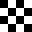

35.15625


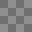

4.151953124999986


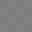

0.0


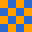

27.03867187499996


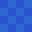

0.0


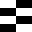

175.78125
CPU times: user 3.79 s, sys: 16.3 ms, total: 3.81 s
Wall time: 3.79 s


In [8]:
%%time

limiar = 10 #abaixo dessa diferença consideramos a mesma cor

def iterador(img):
    largura, altura = img.size
    loaded_img = img.load()
    mudancas = 0
    for linha in range(1, altura-1):
        for coluna in range(1, largura-1):
            if (linha%2 == 0 and coluna%2 == 0) or (linha%2 == 1 and coluna%2 == 1):
                for pixel in valores_vizinhos(loaded_img, coluna, linha):
                    dE = obter_dE(loaded_img[linha, coluna], pixel)
                    if dE > limiar:
                        mudancas += round(dE, 2)
    return mudancas*2/(largura*altura) #como estamos filtrando metade dos pixels, multiplicamos por 2

display(img0a)
print(iterador(img0a))
display(img0b)
print(iterador(img0b))
display(img1)
print(iterador(img1))
display(img2)
print(iterador(img2))
display(img3)
print(iterador(img3))
display(img5)
print(iterador(img5))
display(img6)
print(iterador(img6))
display(img7)
print(iterador(img7))

#### Usando uma lib pronta

100.0


75.0


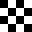

35.15625


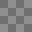

4.151953124999986


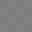

0.0


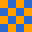

21.280078125000035


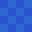

0.0


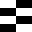

175.78125
CPU times: user 390 ms, sys: 1.99 ms, total: 392 ms
Wall time: 395 ms


In [9]:
%%time

from basic_colormath import get_delta_e

limiar = 10 #abaixo dessa diferença consideramos a mesma cor

def iterador(img):
    largura, altura = img.size
    loaded_img = img.load()
    mudancas = 0
    for linha in range(1, altura-1):
        for coluna in range(1, largura-1):
            if (linha%2 == 0 and coluna%2 == 0) or (linha%2 == 1 and coluna%2 == 1):
                for pixel in valores_vizinhos(loaded_img, coluna, linha):
                    dE = get_delta_e(loaded_img[linha, coluna], pixel)
                    if dE > limiar:
                        mudancas += round(dE, 2)
    return mudancas*2/(largura*altura) #como estamos filtrando metade dos pixels, multiplicamos por 2

display(img0a)
print(iterador(img0a))
display(img0b)
print(iterador(img0b))
display(img1)
print(iterador(img1))
display(img2)
print(iterador(img2))
display(img3)
print(iterador(img3))
display(img5)
print(iterador(img5))
display(img6)
print(iterador(img6))
display(img7)
print(iterador(img7))

